In [1]:
import sys
import numpy as np
import pandas as pd
from fortran import fortran
from scipy.constants import pi, Boltzmann as kb
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# VARIABLE ANGLE

In [3]:
# ============= DECLARING FORTRAN SUBROUTINES =============
abc = fortran.subr1           # Metropolis algorithm
HextCalc = fortran.subr2      # Setting hex value
randomArrays = fortran.subr3  # Create de position, mag and ku arrays at random (Initial configuration)
magTotalSet = fortran.subr4   # Calculating total magnetic field

In [4]:
# ============= DEFINING FIXED PARAMETERS =================
n = 1000                        # Number of nanoparticles
Hmax = 1                        # Magnetic Field (Tesla)
nHstep = 200                    # Number of steps for the field
kuni = 4.7e5                    # Uniaxial anisotropy constant in J/m³
Ms = 1400e3                     # Saturation magnetization in A/m
d = 5e-9                        # Diameter of the nanoparticles in m
nHext = int(5*nHstep/2-2)       # Number of points in M(H) curve


# ============= DEFINING DYNAMIC PARAMETERS =================
mcs = 200                        # Monte Carlo steps
dThet = 20                      # Solid angle for transitions
dThet = dThet*pi/180.0
temp = 20                      # Temperature in Kelvin
Hext = 0.0
magTotal = 0.0

# ============= DECLARING ARRAYS ==========================
mag = np.empty(shape=(int(n),3), order='F')
ku = np.empty(shape=(int(n),3), order='F')
xyz = np.empty(shape=(int(n),3), order='F')
vecH = np.empty(shape=(1,3), order='F')
mhCurve = np.empty(shape=(nHext+1,2), order='F')
initConf = np.empty(shape=(int(n),3), order='F')

# ============= INITIAL CONFIGURATION =====================  
vecH = np.array([0.0,0.0,1.0])  # FIELD DIRECTION
mag, ku, xyz = randomArrays(pi,n)
for i in range(0,n):
    initConf[i] = mag[i]
# FILLIN FILES magData.txt and xyzData.txt
with open("magData.txt","wb") as file:
    np.savetxt(file,mag,delimiter="\t")
with open("xyzData.txt","wb") as file:
    np.savetxt(file,xyz,delimiter="\t")    
# ERASING TRASH DATA IN mhData.txt, this is the M(H) curve data to be plotted
with open("mhData.txt", "w"):
    pass

# ============= CREATING DATAFRAME FOR ARRAYS =============
dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) 
dfXyz = pd.DataFrame(data=xyz[0:,0:],columns=['x','y','z']) 

In [5]:
# ============= PLOTTING INITIAL CONFIGURATION =============
#Normal 3D plot
#%matplotlib inline 
#Interactive 3D plot
#%matplotlib qt 
'''
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=1, color="silver")
ax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.5, color='midnightblue', alpha=0.5)
ax.set_title('3D - Representation', size="xx-large", family="serif", weight= "semibold")
ax.set_xlabel('X',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_ylabel('Y',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_zlabel('Z',fontsize= 20, color="#000000", family="serif", labelpad=20)
plt.show()
'''

'\nfrom mpl_toolkits.mplot3d import Axes3D\nfig = plt.figure(figsize=(15,15))\nax = fig.add_subplot(111, projection=\'3d\')\nax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=1, color="silver")\nax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.5, color=\'midnightblue\', alpha=0.5)\nax.set_title(\'3D - Representation\', size="xx-large", family="serif", weight= "semibold")\nax.set_xlabel(\'X\',fontsize= 20, color="#000000", family="serif", labelpad=20)\nax.set_ylabel(\'Y\',fontsize= 20, color="#000000", family="serif", labelpad=20)\nax.set_zlabel(\'Z\',fontsize= 20, color="#000000", family="serif", labelpad=20)\nplt.show()\n'

In [6]:
# SETTING magTotal
magTotal = magTotalSet(mag, vecH,n)
# FILLING DATAFRAME AND ARRAY
df = pd.DataFrame([
    [Hext, magTotal]
], columns = ["Hext", "MagTotal"])

In [7]:
# ============= DYNAMIC ANGLE (STEP = 20°) ============= 
temp = 20
    
while temp < 101:
    
    
    for angle in range (30,181,30):
        
        #RESTARTING DYNAMIC VARIABLES
        dThet = angle                      
        Hext = 0.00
        magTotal = 0.00
        mag = np.empty(shape=(int(n),3))
        for i in range(0,n):
            mag[i] = initConf[i]
        #dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) 
        #NAMING NEW FILE
        filename = "temp" + str(temp) + "/angle" + str(angle)
        dThet = dThet*pi/180.0
        #RECREATING ARRAY FOR M(H) DATA
        mhCurve = np.empty(shape=(nHext+1,2))
        mhCurve[0,0] = Hext
        mhCurve[0,1] = magTotal
        with open(filename, "w"):
            pass
        # SETTING magTotal AND DATAFRAME USING MARKOV CHAINS
        for i in range(0,nHext):    
            Hext = HextCalc(Hext,nHstep,Hmax,i)   
            for step in range(0,int(mcs)):
                for nanoparticle in range(0,int(n)):
                    randN = round(np.random.rand()*(n-1)) #Random Nanoparticle
                    mag[randN] = abc(vecH, Hext, dThet, ku[randN], pi, mag[randN], d, kuni, Ms, kb, temp)   

            # FILLING FILE magData.txt FOR 3D-PLOT
            # with open("magData.txt","wb") as file:
                # np.savetxt(file,mag,delimiter="\t")      

            magTotal = magTotalSet(mag, vecH,n)   
            print(i,Hext,magTotal)
            df.loc[i+1]=[Hext,magTotal]
            # FILLING FILE mhData.txt
            mhCurve[i+1,0] = Hext
            mhCurve[i+1,1] = magTotal
            with open(filename,'wb') as file:
                np.savetxt(file,mhCurve,delimiter="\t")
    temp = temp + 20

0 0.01 13.736437213495192
1 0.02 18.700774491529852
2 0.03 26.52547808536552
3 0.04 31.090558335209774
4 0.05 45.00893930890842
5 0.060000000000000005 52.33919458085684
6 0.07 59.502137904329004
7 0.08 66.0753328179704
8 0.09 71.14875056874622
9 0.09999999999999999 83.10797390436454
10 0.10999999999999999 88.62084262918572
11 0.11999999999999998 96.36792578985452
12 0.12999999999999998 105.65426453210566
13 0.13999999999999999 112.25790742304712
14 0.15 118.80169800264585
15 0.16 130.46746005645517
16 0.17 139.45003964163453
17 0.18000000000000002 147.25522150300833
18 0.19000000000000003 154.94230723487613
19 0.20000000000000004 165.17503692672153
20 0.21000000000000005 173.11631716952223
21 0.22000000000000006 181.06056840287584
22 0.23000000000000007 192.52279516934783
23 0.24000000000000007 203.73676816288904
24 0.25000000000000006 209.51584973864396
25 0.26000000000000006 218.15622166877938
26 0.2700000000000001 232.45240214149467
27 0.2800000000000001 250.62566392272672
28 0.2900

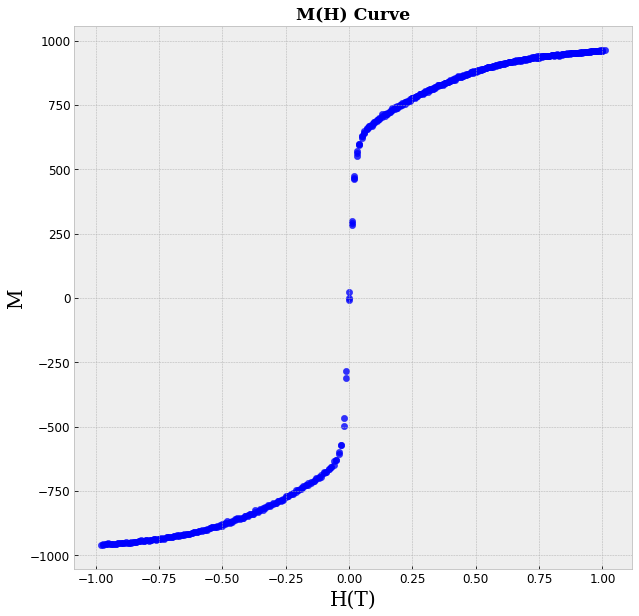

In [8]:
# PLOTTING HYSTERESIS LOOP
plt.style.use("bmh")
ax = df.plot.scatter(x='Hext',y='MagTotal',alpha=0.8, figsize=(10,10), fontsize=12, s=40)
ax.set_title('M(H) Curve', size="xx-large", family="serif", weight= "semibold")
plt.xlabel('H(T)', fontsize= 20, color="#000000", family="serif")
plt.ylabel('M', fontsize= 20, color="#000000", family="serif")
plt.show()